# Artificial data

Methods:
1. Logistic regression with L1 regularization
2. Mutual Information
3. Chi2 test
4. Random Forest features importance
5. Boruta (with Random Forest) + removing correlated features

For each method, an XGBoost classifier was trained on the selected features and the accuracy was calculated. This model was chosen after performing initial experiments to compare different models.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import chi2
from sklearn.metrics import balanced_accuracy_score
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import seaborn as sns

from boruta import BorutaPy
import numpy as np
np.int = int
np.float = float
np.bool = bool

def load_artificial(root='data/', seed=42):
    artificial_train = pd.read_csv(f'{root}artificial_train.data', sep=' ', header=None).dropna(axis=1)
    artificial_train_labels = pd.read_csv(f'{root}artificial_train.labels', sep=' ', header=None).dropna(axis=1)
    artificial_train_labels = (artificial_train_labels[0].values+1)/2
    artificial_test = pd.read_csv(f'{root}artificial_valid.data', sep=' ', header=None).dropna(axis=1)

    X_train, X_valid, y_train, y_valid = train_test_split(artificial_train, artificial_train_labels, test_size=0.2, random_state=seed)
    return X_train, X_valid, y_train, y_valid, artificial_test

def scale_minmax(X_train, X_valid, X_test):
    minmax = MinMaxScaler()
    X_train = minmax.fit_transform(X_train)
    X_valid = minmax.transform(X_valid)
    X_test = minmax.transform(X_test)
    return X_train, X_valid, X_test

def get_importance_mutual_information(X_train, y_train):
    importance = mutual_info_classif(X_train, y_train, random_state=42)
    return importance

def get_importance_chi2(X_train, y_train):
    importance = chi2(X_train, y_train)[0]
    return importance

def get_importance_random_forest(X_train, y_train):
    importance = RandomForestClassifier(max_depth=7, random_state=42, n_estimators=100).fit(X_train, y_train).feature_importances_
    return importance
    
def get_importance_boruta(X_train, y_train):
    rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=7, random_state=42)
    feat_selector = BorutaPy(rf, n_estimators='auto', verbose=0, random_state=42)
    feat_selector.fit(X_train.values, y_train)
    print(f'Number of selected features: {feat_selector.n_features_}')
    return feat_selector.ranking_

def get_top_features(X, importances, num_of_features):
    importance_threshold = sorted(importances, reverse=True)[num_of_features]
    return X.iloc[:, importances > importance_threshold]

def get_accuracies(model, model_params_dict, X_train, y_train, X_valid, y_valid):
    model_object = model(**model_params_dict)
    model_object.fit(X_train, y_train)
    y_pred_train = model_object.predict(X_train)
    y_pred_valid = model_object.predict(X_valid)
    balanced_accuracy_train = balanced_accuracy_score(y_train, y_pred_train)
    balanced_accuracy_valid = balanced_accuracy_score(y_valid, y_pred_valid)
    return balanced_accuracy_train, balanced_accuracy_valid

def get_score(accuracy, desired_features, num_of_selected_features):
    return accuracy - 0.01 * max(0, num_of_selected_features / desired_features - 1)

def get_results_df_by_features(importance, model, model_params_dict, X_train, y_train, X_valid, y_valid, desired_features, features_min, features_max, step):
    results = []
    for i in tqdm(list(range(features_min, features_max, step))):
        X_train_filtered, X_valid_filtered = get_top_features(X_train, importance, i), get_top_features(X_valid, importance, i)
        acc_train, acc_valid = get_accuracies(model, model_params_dict, X_train_filtered, y_train, X_valid_filtered, y_valid)
        score = get_score(acc_valid, desired_features, i)
        results.append({'Features': i, 'Train acc': acc_train, 'Valid acc': acc_valid, 'Score': score})
    results_df = pd.DataFrame(results)
    return results_df

def get_results_df_by_features_boruta(importance, model, model_params_dict, X_train, y_train, X_valid, y_valid, desired_features, features_min, features_max, step):
    X_train_boruta, X_valid_boruta = X_train.iloc[:, importance == 1], X_valid.iloc[:, importance == 1]
    corr_matrix = X_train_boruta.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

    thresholds = np.arange(0.01, 1.02, 0.05)
    results = []
    for threshold in tqdm(thresholds):
        to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
        X_train_filtered, X_valid_filtered = X_train_boruta.drop(to_drop, axis=1), X_valid_boruta.drop(to_drop, axis=1)
        i = X_train_filtered.shape[1]
        if i < features_min or i > features_max:
            continue
        acc_train, acc_valid = get_accuracies(model, model_params_dict, X_train_filtered, y_train, X_valid_filtered, y_valid)
        score = get_score(acc_valid, desired_features, i)
        results.append({'Features': i, 'Train acc': acc_train, 'Valid acc': acc_valid, 'Score': score})
    results_df = pd.DataFrame(results)
    return results_df

def make_plot_by_features(results_df, title):
    fig, ax = plt.subplots(figsize=(5, 3))
    sns.lineplot(data=results_df, x='Features', y='Score', ax=ax, label='Score', color='blue', linestyle='--')
    sns.lineplot(data=results_df, x='Features', y='Train acc', ax=ax, label='Train acc', color='green')
    sns.lineplot(data=results_df, x='Features', y='Valid acc', ax=ax, label='Valid acc', color='red')
    ax.set_title(title)
    ax.set_xlabel('Number of features')
    ax.set_ylabel('Score/Accuracy')
    ax.legend()
    plt.show()

def plot_first_k_percent_importances(importances, title, k):
    sorted_importances = sorted(importances, reverse=True)[:int(len(importances) * k/100)]
    fig, ax = plt.subplots(figsize=(5, 3))
    ax.bar(range(1, 1+len(sorted_importances)), sorted_importances)
    ax.set_title(title)
    ax.set_xlabel('Feature number')
    ax.set_ylabel('Importance')
    plt.show()
    
def print_results_for_specific_features(results_df, min_features, max_features, method_name):
    results_filtered = results_df[(results_df['Features'] >= min_features) & (results_df['Features'] <= max_features)]
    results_filtered = results_filtered.sort_values(by='Score', ascending=False)
    print(results_filtered.head(1))
    dict_result = results_filtered.head(1).to_dict('records')[0] 
    dict_result['Method'] = method_name
    return dict_result

Settings for XGboost models (same for all methods).

In [2]:
from xgboost import XGBClassifier
model = XGBClassifier
model_params_dict = {
    'n_estimators': 100,
    'max_depth': 7,
    'random_state': 42
}
desired_features = 5
features_min = 1
features_max = 25
step = 1

In [3]:
# from utils import *

Load and split data.

In [4]:
X_train, X_valid, y_train, y_valid, artificial_test = load_artificial()

Store best results for each method.

In [5]:
final_results = []

## Mutual information

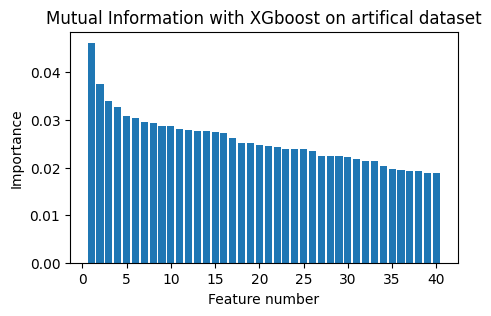

100%|██████████| 24/24 [00:04<00:00,  5.08it/s]


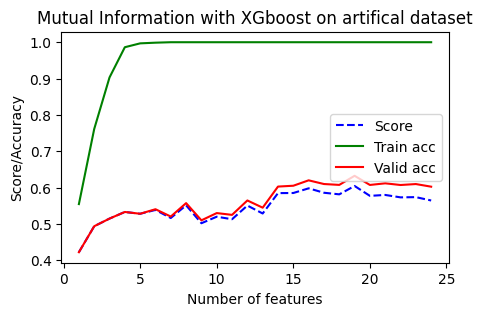

In [6]:
importances = get_importance_mutual_information(X_train, y_train)
plot_first_k_percent_importances(importances, 'Mutual Information with XGboost on artifical dataset', 8)
results_df = get_results_df_by_features(importances, model, model_params_dict, 
                                        X_train, y_train, X_valid, y_valid, 
                                        desired_features, features_min, features_max, step)
make_plot_by_features(results_df, 'Mutual Information with XGboost on artifical dataset')

In [7]:
min_features = 12
max_features = 15
method_name = 'Mutual information'

final_results.append(print_results_for_specific_features(results_df, min_features, max_features, method_name))

    Features  Train acc  Valid acc     Score
14        15        1.0   0.605136  0.585136


## Chi2 test

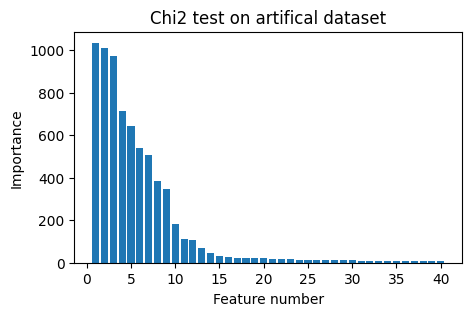

100%|██████████| 24/24 [00:04<00:00,  5.52it/s]


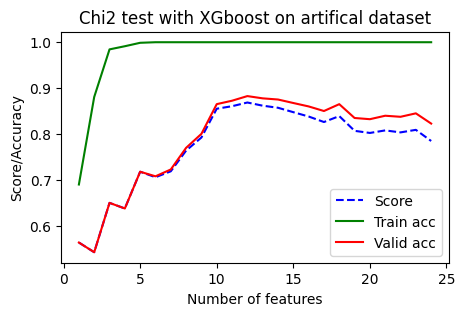

In [8]:
importances = get_importance_chi2(X_train, y_train)
plot_first_k_percent_importances(importances, 'Chi2 test on artifical dataset', 8)
results_df = get_results_df_by_features(importances, model, model_params_dict, 
                                        X_train, y_train, X_valid, y_valid, 
                                        desired_features, features_min, features_max, step)
make_plot_by_features(results_df, 'Chi2 test with XGboost on artifical dataset')

In [9]:
min_features = 9
max_features = 13
method_name = 'Chi2 test'

final_results.append(print_results_for_specific_features(results_df, min_features, max_features, method_name))

    Features  Train acc  Valid acc     Score
11        12        1.0   0.882511  0.868511


## Random Forest features importance

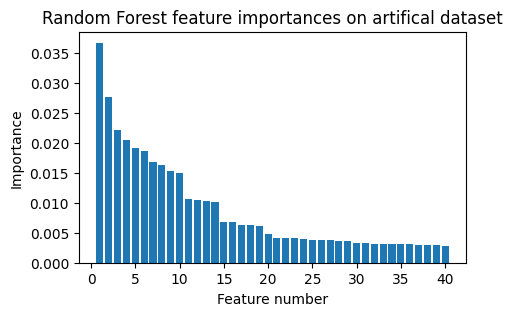

100%|██████████| 24/24 [00:03<00:00,  6.11it/s]


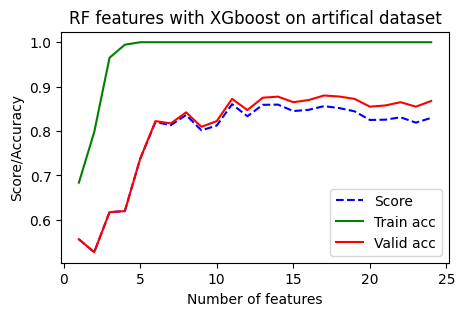

In [10]:
importances = get_importance_random_forest(X_train, y_train)
plot_first_k_percent_importances(importances, 'Random Forest feature importances on artifical dataset', k=8)
results_df = get_results_df_by_features(importances, model, model_params_dict, 
                                        X_train, y_train, X_valid, y_valid, 
                                        desired_features, features_min, features_max, step)
make_plot_by_features(results_df, 'RF features with XGboost on artifical dataset')

In [11]:
min_features = 5
max_features = 13
method_name = 'Random Forest'

final_results.append(print_results_for_specific_features(results_df, min_features, max_features, method_name))

    Features  Train acc  Valid acc     Score
10        11        1.0   0.872434  0.860434


## Boruta

In [58]:
# from boruta import BorutaPy
# import numpy as np
# np.int = int
# np.float = float
# np.bool = bool

# def get_importance_boruta(X_train, y_train):
#     rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=7, random_state=42)
#     feat_selector = BorutaPy(rf, n_estimators='auto', verbose=0, random_state=42)
#     feat_selector.fit(X_train.values, y_train)
#     print(f'Number of selected features: {feat_selector.n_features_}')
#     return feat_selector.ranking_

In [18]:
importances = get_importance_boruta(X_train, y_train)

Number of selected features: 21


In [19]:
# def get_results_df_by_features_boruta(importance, model, model_params_dict, X_train, y_train, X_valid, y_valid, desired_features, features_min, features_max, step):
#     X_train_boruta, X_valid_boruta = X_train.iloc[:, importance == 1], X_valid.iloc[:, importance == 1]
#     corr_matrix = X_train_boruta.corr().abs()
#     upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

#     thresholds = np.arange(0.01, 1.02, 0.05)
#     results = []
#     for threshold in tqdm(thresholds):
#         to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
#         X_train_filtered, X_valid_filtered = X_train_boruta.drop(to_drop, axis=1), X_valid_boruta.drop(to_drop, axis=1)
#         i = X_train_filtered.shape[1]
#         if i < features_min or i > features_max:
#             continue
#         acc_train, acc_valid = get_accuracies(model, model_params_dict, X_train_filtered, y_train, X_valid_filtered, y_valid)
#         score = get_score(acc_valid, desired_features, i)
#         results.append({'Features': i, 'Train acc': acc_train, 'Valid acc': acc_valid, 'Score': score})
#     results_df = pd.DataFrame(results)
#     return results_df

100%|██████████| 21/21 [00:03<00:00,  6.08it/s]


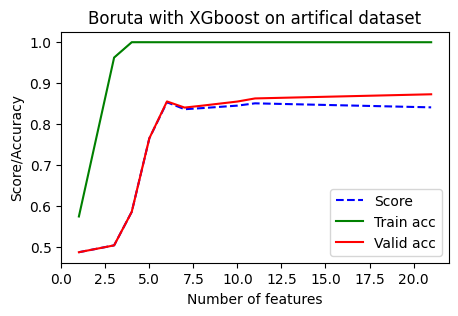

In [20]:
results_df = get_results_df_by_features_boruta(importances, model, model_params_dict, 
                                        X_train, y_train, X_valid, y_valid, 
                                        desired_features, features_min, features_max, step)
make_plot_by_features(results_df, 'Boruta with XGboost on artifical dataset')

In [21]:
min_features = 5
max_features = 10
method_name = 'Boruta'

final_results.append(print_results_for_specific_features(results_df, min_features, max_features, method_name))

    Features  Train acc  Valid acc     Score
11         6        1.0   0.855042  0.853042


# Summary

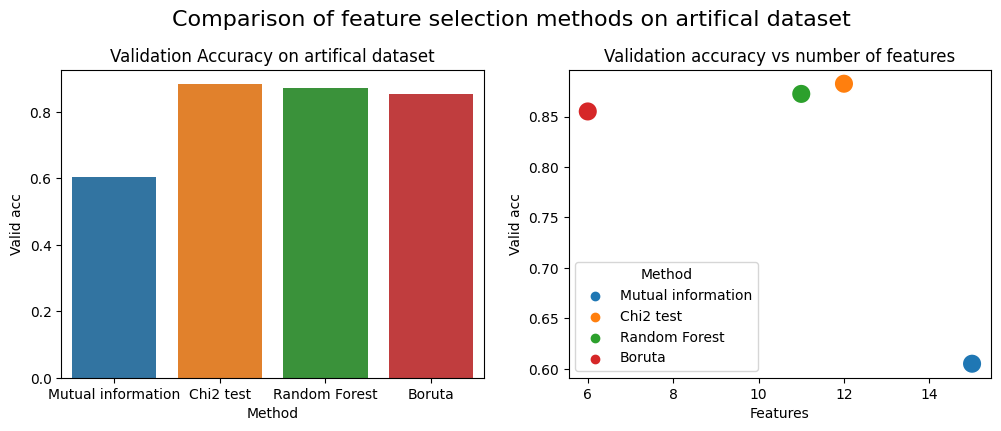

,Features,Train acc,Valid acc,Score,Method
0,15,1.0,0.605136,0.585136,Mutual information
1,12,1.0,0.882511,0.868511,Chi2 test
2,11,1.0,0.872434,0.860434,Random Forest
3,6,1.0,0.855042,0.853042,Boruta


In [41]:
final_results_df = pd.DataFrame(final_results)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.barplot(x='Method', y='Valid acc', data=final_results_df, ax=ax[0])
ax[0].set_title('Validation Accuracy on artifical dataset')

sns.scatterplot(x='Features', y='Valid acc', hue='Method', data=final_results_df, ax=ax[1], s=200)
ax[1].set_title('Validation accuracy vs number of features')
fig.suptitle('Comparison of feature selection methods on artifical dataset', fontsize=16, y=1.03)
plt.show()

final_results_df

# Saving predictions